https://cytopath.readthedocs.io/en/latest/usage.html

In [2]:
import sys
sys.path = ["../.."] + sys.path # 切换到项目目录下

import numpy as np
import scanpy as sc
import scvelo as scv
import velovgi

Global seed set to 0
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
adata_dir = "tmp/erythroid_lineage2/adata"
adata = velovgi.tl.read_adata(adata_dir)
batch_key = "stage"
cluster_key = "celltype"
adata

load tmp/erythroid_lineage2/adata/adata.h5ad
load tmp/erythroid_lineage2/adata/sample_recover.pkl


AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

In [24]:
adata.uns['T_forward'] = scv.utils.get_transition_matrix(adata)
scv.tl.terminal_states(adata) # 找起始、终止状态
# 细胞较少时找的不准，手动指定
adata.obs.loc[adata.obs[cluster_key] == "Blood progenitors 1", "root_cells"] = 1
adata.obs.loc[adata.obs[cluster_key] == "Erythroid3", "end_points"] = 1

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 6 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


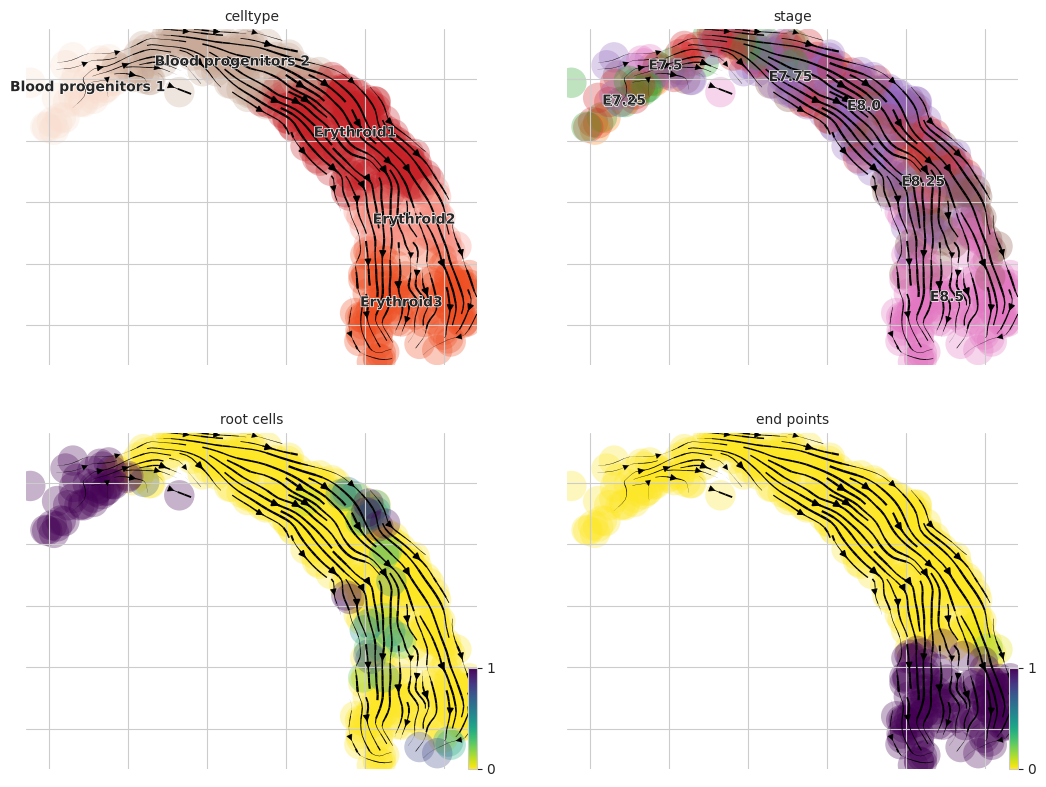

In [25]:
scv.pl.velocity_embedding_stream(adata, color=[cluster_key, batch_key, 'root_cells', 'end_points'],
                                             ncols=2, legend_loc='on data')

In [28]:
import os
import cytopath

cytopath.sampling(adata, auto_adjust=True, matrix_key = 'T_forward', cluster_key = cluster_key,
                  num_cores=os.cpu_count()-1, copy=False)

Adjusting simulation parameters based on dataset properties. Set auto_adjust=False if this is unwanted.
Number of required simulations per end point (traj_number) set to 135
Number of initial simulations (sim_number) set to 733


Iterating state probability distributions:   0%|          | 0/200 [00:00<?, ?it/s]

Tolerance reached after 37 iterations of 200.
Number of initial simulation steps (max_steps) set to 37

Sampling round: 0


  0%|          | 0/42 [00:00<?, ?it/s]

1398.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1398.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1398.80s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1398.82s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1398.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1398.88s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1398.89s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1398.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1398.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1398.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1398.97s - pydevd: Sending message related to proc

IndexError: index -1 is out of bounds for axis 0 with size 0

更加严格地控制起始点

In [8]:
cytopath.sampling(adata, num_cores=os.cpu_count()-1, cluster_key = cluster_key)

Adjusting simulation parameters based on dataset properties. Set auto_adjust=False if this is unwanted.
Number of required simulations per end point (traj_number) set to 135
Number of initial simulations (sim_number) set to 484


Iterating state probability distributions:   0%|          | 0/200 [00:00<?, ?it/s]

Tolerance reached after 32 iterations of 200.
Number of initial simulation steps (max_steps) set to 32

Sampling round: 0


  0%|          | 0/11 [00:00<?, ?it/s]

IndexError: index -1 is out of bounds for axis 0 with size 0

In [6]:
end_points = np.array(adata.obs.end_points > 0.99)[0] # Numerical index; use any selection criteria
root_cells = np.array(adata.obs.root_cells > 0.99)[0] # Numerical index; use any selection criteria

cytopath.sampling(adata, auto_adjust=True, matrix_key = 'T_forward', cluster_key = cluster_key,
                  end_points=end_points, root_cells=root_cells, num_cores=os.cpu_count()-1, copy=False)

Adjusting simulation parameters based on dataset properties. Set auto_adjust=False if this is unwanted.
Number of required simulations per end point (traj_number) set to 135
Number of initial simulations (sim_number) set to 484


Iterating state probability distributions:   0%|          | 0/200 [00:00<?, ?it/s]

Tolerance reached after 32 iterations of 200.
Number of initial simulation steps (max_steps) set to 32

Sampling round: 0


  0%|          | 0/11 [00:00<?, ?it/s]

IndexError: index -1 is out of bounds for axis 0 with size 0